# Joint Line Fit

Create $m$ data sets generated from a linear relation with the same slope but different constant offsets (intercepts).

Perform a chi-square fit to find the common slope and the two intercepts.

Then subclass the `LinFit` class in the [hyperfit](https://hyperfit.readthedocs.io/en/latest/) package to perform the same joint fit using `hyperfit`.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.special import loggamma
from scipy.optimize import minimize, differential_evolution

from corner import corner

import emcee
from hyperfit.linfit import LinFit

In [2]:
mpl.rc('font', size=14)

## Generate Data

Generate $m$ independent data sets of different sizes of the form

$$
\begin{align}
y_i^{(1)} &= ax_i^{(1)} + b^{(1)} \\
y_i^{(2)} &= ax_i^{(2)} + b^{(2)} \\
&\vdots \\
y_i^{(m)} &= ax_i^{(m)} + b^{(m)}
\end{align}
$$

I.e., the data share a slope but have different constant offsets. The data will also have separate covariances.

In [3]:
m = 7
n = np.random.poisson(20, size=m)

# Common slope but different intercepts.
a, b = 4., np.arange(1, m+1)

# Generate the m data sets. Pack the results into arrays data and cov.
data, cov = [], []
for k in np.arange(m):
    x = np.random.rand(n[k])
    y = np.random.normal(a*x + b[k], 0.2)

    dx, dy, corrxy = (
        0.05 * np.random.rand(n[k]) + 0.025,
        0.1 * np.random.rand(n[k]) + 0.025,
        2.0 * (np.random.rand(n[k]) - 0.5)
    )
    datak, covk = np.empty((2,n[k])), np.empty((2,2,n[k]))
    for j, (_x, _y, _ex, _ey, _rhoxy) in enumerate(zip(x, y, dx, dy, corrxy)):
        covk[:,:,j] = np.array([[_ex**2, _ex*_ey*_rhoxy], [_ex*_ey*_rhoxy, _ey**2]])
        datak[:,j]  = np.random.multivariate_normal([_x, _y], covk[:,:,j])

    data.append(datak)
    cov.append(covk)

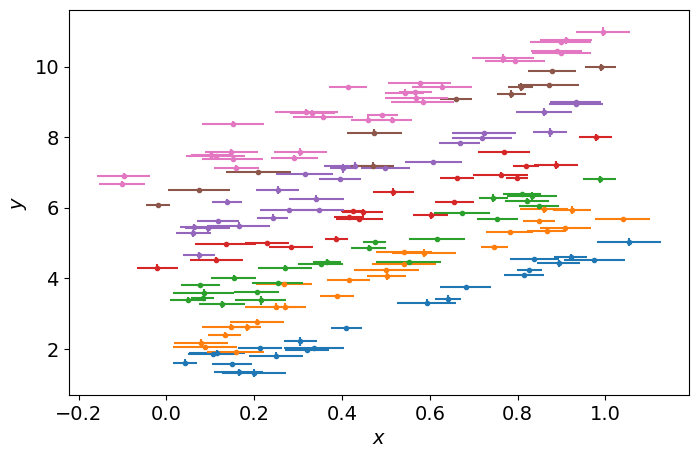

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
for k in np.arange(m):
    eb = ax.errorbar(data[k][0], data[k][1], xerr=np.sqrt(cov[k][0,0]), yerr=np.sqrt(cov[k][1,1]), fmt='.')
ax.set(xlabel='$x$', ylabel='$y$');

## Standard Fit

Attempt a standard $\chi^2$ fit to the data. Use both the uncertainties in $x$ and $y$, but ignore the covariances. Here we use the form of the $\chi^2$ defined in **Numerical Recipes in C++**, eq. 15.3.2:

$$
\chi^2(a,b) = \sum_{i}\frac{(y_i-ax_i-b)^2}{\sigma_{y_i}^2 + a^2\sigma_{x_i}^2}
$$

In this case, we divide the data in two and specify the parameters as the array `[a, b1, b2, ..., bm]`.

In [5]:
def chi2(params, data, cov):
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data : ndarray
        MxN array of x-y data.
    cov : ndarray
        Mx2x2xN covariances for data.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to all data sets.
    """
    a, b = params[0], params[1:]
    m = len(b)
    chi2 = 0.

    for k in np.arange(m):
        x, y = data[k][0], data[k][1]
        varx, vary = cov[k][0,0], cov[k][1,1]
        chi2 += np.sum((y - a*x - b[k])**2 / (vary + a**2*varx))

    return chi2

### Peform the Fit and Plot Results

Use the `BFGS` minimizer to find the best fit parameters.

Note that the result may depend sensitively on the initial seed values.

In [6]:
a0 = [1.5]
b0 = np.random.normal(loc=0., scale=0.5, size=m) + np.arange(m)
p0 = np.concatenate([a0, b0])

res = minimize(chi2, p0, args=(data, cov), method='BFGS')
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 325.4751895941367
        x: [ 4.086e+00  9.361e-01  2.000e+00  2.982e+00  3.909e+00
             5.064e+00  6.090e+00  6.924e+00]
      nit: 37
      jac: [ 3.815e-06  3.815e-06  3.815e-06  3.815e-06  7.629e-06
             0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[ 1.976e-03 -1.009e-03 ... -8.889e-04 -6.044e-04]
            [-1.009e-03  1.081e-03 ...  3.777e-04  3.454e-04]
            ...
            [-8.889e-04  3.777e-04 ...  1.788e-03  2.020e-04]
            [-6.044e-04  3.454e-04 ...  2.020e-04  9.717e-04]]
     nfev: 432
     njev: 48

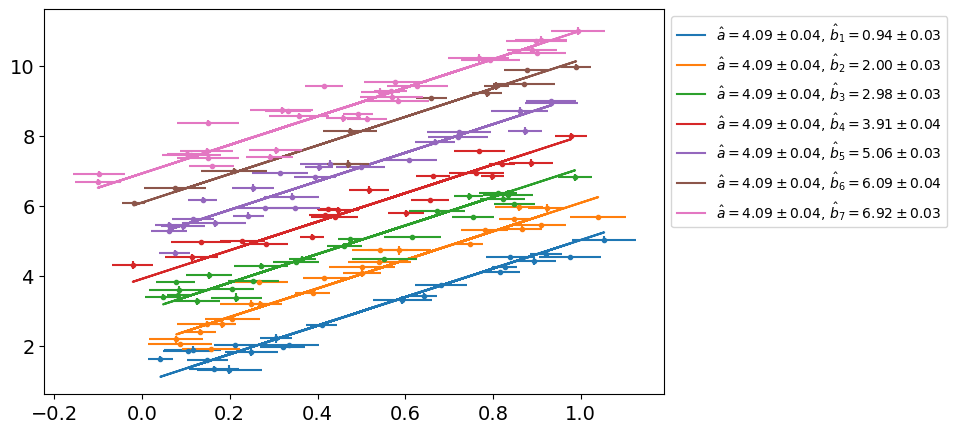

In [7]:
a_, b_ = res.x[0], res.x[1:]
da_ = np.sqrt(res.hess_inv[0,0])
db_ = [np.sqrt(res.hess_inv[i,i]) for i in range(1, m+1)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
for k in np.arange(m):
    eb = ax.errorbar(x=data[k][0], y=data[k][1], xerr=np.sqrt(cov[k][0,0]), yerr=np.sqrt(cov[k][1,1]), fmt='.')
    ax.plot(data[k][0], a_*data[k][0] + b_[k], color=eb[0].get_color(),
            label=rf'$\hat{{a}}={a_:.2f}\pm{da_:.2f}$, $\hat{{b}}_{k+1}={b_[k]:.2f}\pm{db_[k]:.2f}$')
    
ax.legend(fontsize=10, bbox_to_anchor=(1, 1));

## Enable a Joint Fit in `hyperfit`

Here we set up a new class that can handle multiple data sets at once. The main condition is that the linear fits to the data always have a common slope.

In [8]:
def nlogl(params, datasets, covs):
    """Chi-square function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        Mx2xN array of [x1, y1] for each data set.
    cov : ndarray
        Mx2x2xN covariances for each data set.
        
    Returns
    -------
    nloglike : float
        Negative log likelihood of best linear fit.
    """
    m = len(datasets)
    a = params[0]
    b = params[1:m+1]
    sigma = params[m+1:]
    
    nloglike = 0.
    for k in np.arange(m): 
        data = datasets[k]
        cov = covs[k]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma[k]**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[k])**2/sy2)
    
    return nloglike

# Minimization using differential evolution (no initial guess, no Hessian returned):
print('Differential evolution:')
bounds = [[-10, 10]]         # Bounds on a (slope)
bounds += m * [(-10, 10)]    # Bounds on b (intercepts)
bounds += m * [(0, 2)]       # Bounds on sigmas
res = differential_evolution(nlogl, bounds, args=(data, cov))
print(res)

# Minimization with BFGS or L-BFGS-B (initial guess needed, Hessian returned):
slope = 1.5
intercepts = m * [4]
sigmas = m * [0.25]
p0 = [slope] + intercepts + sigmas

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=(data, cov), bounds=bounds, method='L-BFGS-B')
print(res)

Differential evolution:
 message: Optimization terminated successfully.
 success: True
     fun: -333.5737834537178
       x: [ 4.119e+00  9.013e-01 ...  1.537e-01  2.691e-01]
     nit: 77
    nfev: 17822
     jac: [-1.211e-03  9.152e-04 ... -2.387e-04  1.199e-03]


BFGS minimization:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -333.5737834490942
        x: [ 4.119e+00  9.013e-01 ...  1.537e-01  2.690e-01]
      nit: 34
      jac: [ 9.550e-04 -1.648e-04 ... -6.878e-04 -4.832e-04]
     nfev: 816
     njev: 51
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>


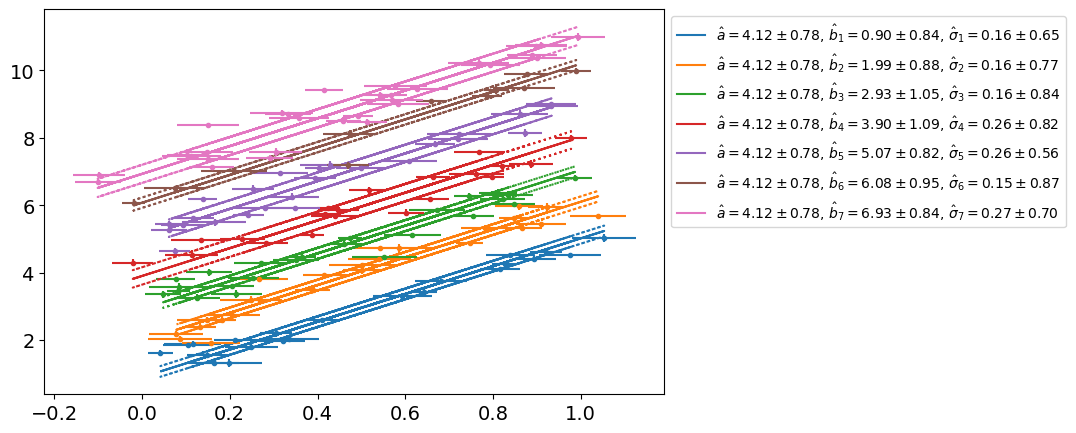

In [9]:
a_, b_, sig_ = res.x[0], res.x[1:m+1], res.x[m+1:]

#- Account for different forms of the inverse Hessian in case we use L-BFGS-B minimization.
hess_inv = res.hess_inv if isinstance(res.hess_inv, np.ndarray) else res.hess_inv.todense()

da_ = np.sqrt(hess_inv[0,0])
db_ = [np.sqrt(hess_inv[i,i]) for i in range(1, m+1)]
dsig_ = [np.sqrt(hess_inv[i,i]) for i in range(m+1, 2*m+1)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
for k in np.arange(m):
    eb = ax.errorbar(x=data[k][0], y=data[k][1], xerr=np.sqrt(cov[k][0,0]), yerr=np.sqrt(cov[k][1,1]), fmt='.')
    ax.plot(data[k][0], a_*data[k][0] + b_[k], color=eb[0].get_color(),
            label=rf'$\hat{{a}}={a_:.2f}\pm{da_:.2f}$, $\hat{{b}}_{k+1}={b_[k]:.2f}\pm{db_[k]:.2f}$, ' \
                  rf'$\hat{{\sigma}}_{k+1}={sig_[k]:.2f}\pm{dsig_[k]:.2f}$')
    ax.plot(data[k][0], a_*data[k][0] + b_[k] + sig_[k], ls=':', color=eb[0].get_color())
    ax.plot(data[k][0], a_*data[k][0] + b_[k] - sig_[k], ls=':', color=eb[0].get_color())
    
ax.legend(fontsize=10, bbox_to_anchor=(1, 1));

## Encapsulate Multi-Dataset Fits in a Single Class

Define a class `MultiLinFit` that takes in a list of datasets and covariances, each in the same format used by `LinFit` in the hyperfit package. I.e.,
* `data` are 2xN arrays, and `datasets` is a list of `data`.
* `cov` are 2x2xN arrays, and `covs` is a list of `cov`.

Note that the data sets can be different sizes.

While the `LinFit` class allows for higher-dimensional fits -- planes and hyperplanes in addition to lines -- this class only fits lines, as needed for the Tully-Fisher relation. It is assumed that all data sets share a common slope but have different intercepts and scatter parameters. The fit parameters are of the form

$$
\vec{\theta} = (a, b_1, b_2, \ldots, b_m, \sigma_1, \sigma_2, \ldots, \sigma_m),
$$

where $a$ is the common slope, $b_1,\ldots,b_m$ are the intercepts for the $m$ datasets, and $\sigma_1,\ldots,\sigma_m$ are the scatter parameters for each dataset.

In [10]:
class MultiLinFit:
    """Class to implement linear fits to multiple datasets, assuming
    a common slope but different intercepts across each set.
    
    Based on the hyperfit algorithm of Robotham and Obreschkow (PASP 2015)
    and the Python LinFit implementation of Howlett and Gordon
    (https://hyperfit.readthedocs.io/en/latest/).
    
    Attributes
    ----------
    nsets : int
        Number of data sets and covariances entered by user.
    ndims : int
        Dimensionality of the data (expect 2).
    ndata : ndarray
        Array giving the length of every input data vector.
    params : ndarray
        Best-fit linear parameters for the data sets.
    params_scatter : ndarray
        Best-fit scatters along the y-axis for each data set.
    
    Parameters
    ----------
    datasets : list or ndarray
        An Mx2xN array of 2xN data vectors.
    covs : list or ndarray
        An Mx2x2xN array of 2x2xN covariance matrices.
    weights : ndarray
        Array of weights for each data set. Unit weights if not specified.
    vertaxis : float
        Specify which coordinate axis in data is the 'vertical' one. Defaults to last axis (-1).
    """
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):
        
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = np.array([np.shape(data)[1] for data in datasets])
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts + sigmas
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(self.nsets)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    # Log posterior function.
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[self.nsets+1+i]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[self.nsets+1+i]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
        
        return lnpost
            
    # Log prior function.
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    # Log likelihood function.
    def _lnlike(self, params):
        a, b, sigma = params

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def bessel_cochran(self, sigma):
        """Bessel-Cochran correction of sample scatter to population scatter.
        
        Parameters
        ----------
        sigma : ndarray
            1xM array of scatters for the M input datasets.
        
        Returns
        -------
        sigma_corr : ndarray
            1xM array of corrected scatter parameters.
        """
        sigma_corr = (
            np.sqrt(0.5 * self.ndata)
            * np.exp(loggamma(0.5 * (self.ndata - self.ndims)) - loggamma(0.5 * (self.ndata - self.ndims + 1.0)))
        ) * sigma

        return sigma_corr
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        """Find the best-fit line for multiple datasets, assuming a
        common slope across all sets but independent intercepts and scatters.
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        tol : float
            Optimization tolerance.
        verbose : bool
            Print fit result.
            
        Returns
        -------
        params : ndarray
            Array of best-fit slope and intercepts [a, b1, b2, ..., bm]
        params_scatter : ndarray
            Array of vertical axis scatter parameters [sig1, sig2, ... sigm]
        log_posterior : float
            Value of ln(posterior) at the best fit point.
        """
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
            
        self.params = res.x[:-self.nsets]
        self.params_scatter = np.fabs(res.x[-self.nsets:])
        self.params_scatter = self.bessel_cochran(self.params_scatter)
        return self.params, self.params_scatter, -res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, skip_initial_state_check=False, verbose=False):
        """Run MCMC using the emcee EnsembleSampler.
        
        The MCMC is seeded using a randomization of the best-fit values of the
        common slope, intercepts, and vertical scatters [a, b1, ..., bm, sig1, ..., sigm].
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        max_iter : int
            Maximum number of MCMC iterations.
        batchsize : int
            Size of each batch. Convergence checked after each batch.
        ntau : float
            Minimum autocorrelation length to consider for convergence.
        tautol : float
            Maximum fractional deviation between successive autocorrelation lengths for convergence.
        skip_initial_state_check : boolean
            Whether or not to check the initial state.  Default is False (check state).
        verbose : bool
            Print out convergence statistics and progress bars if True.
            
        Returns
        -------
        mcmc_samples : ndarray
            Array of flattened and burned-in MCMC samples.
        mcmc_lnlike : ndarray
            Log-likelihood values of every MCMC sample.
        """

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, self.params_scatter])]
            for _ in range(nwalker)
        ])
        
        if np.any(np.isinf(seeds)):
            print('Some of the seeds are infinite!')
        elif np.any(np.isnan(seeds)):
            print('Some of the seeds are NaN!')

        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose, skip_initial_state_check=skip_initial_state_check)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [11]:
mlf = MultiLinFit(data, cov)

In [12]:
mlf.params_scatter, mlf.ndata, mlf.ndims, mlf.npars

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([22, 25, 24, 20, 25, 11, 30]),
 2,
 8)

In [13]:
bounds = [[-10, 10]]         # Bounds on a (slope)
bounds += m * [(-10, 10)]    # Bounds on b (intercepts)
bounds += m * [(0, 2)]       # Bounds on sigmas

mlf.optimize(bounds, verbose=True)

 message: Optimization terminated successfully.
 success: True
     fun: -7877.534761836972
       x: [ 4.130e+00  8.955e-01 ...  1.541e-01  2.694e-01]
     nit: 150
    nfev: 34103
     jac: [ 1.875e-01 -7.703e-02 ...  1.409e-01  1.328e-02]


(array([4.13042682, 0.89552148, 1.98060104, 2.92063308, 3.89797964,
        5.06359842, 6.06862869, 6.92562704]),
 array([0.17039548, 0.16543312, 0.17595764, 0.2764501 , 0.27124284,
        0.17518391, 0.28137324]),
 7877.534761836972)

In [14]:
# Run an MCMC
bounds = [[-10, 10]]         # Bounds on a (slope)
bounds += m * [(-10, 10)]    # Bounds on b (intercepts)
bounds += m * [(0, 2)]       # Bounds on sigmas

mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=10000, verbose=True)#, skip_initial_state_check=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

 message: Optimization terminated successfully.
 success: True
     fun: -7877.534802000804
       x: [ 4.130e+00  8.956e-01 ...  1.541e-01  2.694e-01]
     nit: 191
    nfev: 43408
     jac: [ 1.037e-02 -2.292e-02 ...  1.006e-01 -4.693e-02]


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.84it/s]


Niterations/Max Iterations:  1000 / 10000
Integrated ACT/Min Convergence Iterations:  [72.92008464 69.59157996 70.07170552 78.17408994 74.11176161 68.65252919
 72.0532208  72.10082475 82.9028155  68.91945607 77.37524358 70.08092459
 72.11321731 78.10506321 80.40648788] / 4145.140775189741


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.11it/s]


Niterations/Max Iterations:  2000 / 10000
Integrated ACT/Min Convergence Iterations:  [86.90573328 88.55159413 85.25497813 82.61732917 85.85873686 85.36139505
 98.08416807 78.83942244 93.31930829 98.89529248 90.99050653 90.17098546
 84.15035789 84.16359305 92.17314359] / 4944.764624028467


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.01it/s]


Niterations/Max Iterations:  3000 / 10000
Integrated ACT/Min Convergence Iterations:  [ 88.6365797  100.82643229  96.97059745  87.00641718  95.78166162
  92.83297043  98.8795918   90.2894089  103.64902633  94.79151793
 100.35071466  96.99037115  94.17212384 100.87800855  94.81376262] / 5182.45131633757


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.89it/s]


Niterations/Max Iterations:  4000 / 10000
Integrated ACT/Min Convergence Iterations:  [105.34947931  99.67283479 117.53774129  97.79692613 106.19951011
 102.11746526 101.64191296  98.57368026 112.22520989  99.47117107
 110.76948622  94.71420483 105.88037852 105.80172142 102.25506644] / 5876.887064445258


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.97it/s]


Niterations/Max Iterations:  5000 / 10000
Integrated ACT/Min Convergence Iterations:  [117.21114178 112.53335612 114.69952638 110.55594353 114.63021169
 109.76725603 115.61802871 113.61539118 115.11799638 106.35997924
 114.02937579  98.18191582 110.71232428 114.89982114 105.75980643] / 5860.557088993627


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.38it/s]


Niterations/Max Iterations:  6000 / 10000
Integrated ACT/Min Convergence Iterations:  [114.6030054  122.3700318  118.57527976 109.59354044 112.2535513
 115.73188765 129.92014082 118.87472448 115.77244902 112.9836661
 116.98477504 106.50481972 107.21887054 113.98916917 112.44001553] / 6496.007041094887


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.62it/s]


Niterations/Max Iterations:  7000 / 10000
Integrated ACT/Min Convergence Iterations:  [119.82993686 138.33449577 124.53777038 114.4276983  127.57998924
 115.26706852 131.24122044 118.54912496 113.47032111 121.75749929
 128.75653191 116.80034278 113.54508226 121.33962676 118.47726048] / 6916.724788338981


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.13it/s]


Niterations/Max Iterations:  8000 / 10000
Integrated ACT/Min Convergence Iterations:  [121.08323874 153.5506742  125.15079433 115.17337362 131.60166083
 117.78421852 143.3806595  125.59879931 118.1837357  127.5105384
 128.71136449 120.41136211 121.58794219 124.8333447  124.73045464] / 7677.53370999657


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.12it/s]


Niterations/Max Iterations:  9000 / 10000
Integrated ACT/Min Convergence Iterations:  [131.25290113 155.7291335  135.70144772 117.75735204 135.50787374
 127.68846901 148.55113603 117.53636188 117.84122509 131.2886688
 129.58590194 123.48686208 123.90841451 125.2807464  134.74104027] / 7786.45667522735


100%|██████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.18it/s]


Niterations/Max Iterations:  10000 / 10000
Integrated ACT/Min Convergence Iterations:  [133.72298565 156.39442138 139.05458743 120.43727539 144.11913525
 125.49838036 141.35547285 122.59905773 127.18914732 134.81100457
 134.96525141 123.40596201 126.43919545 128.16551335 132.0864785 ] / 7819.721068979195
[4.13240357 0.89441951 1.97983148 2.92010484 3.89747371 5.06254433
 6.06655088 6.92461941 0.16364298 0.15943373 0.16919325 0.26268289
 0.26035542 0.1630644  0.27177936] [0.01885282 0.0154501  0.0145559  0.01436539 0.02014044 0.01641037
 0.02897622 0.01605676 0.01216973 0.0137322  0.01159706 0.01407814
 0.01178045 0.02501512 0.01152025]


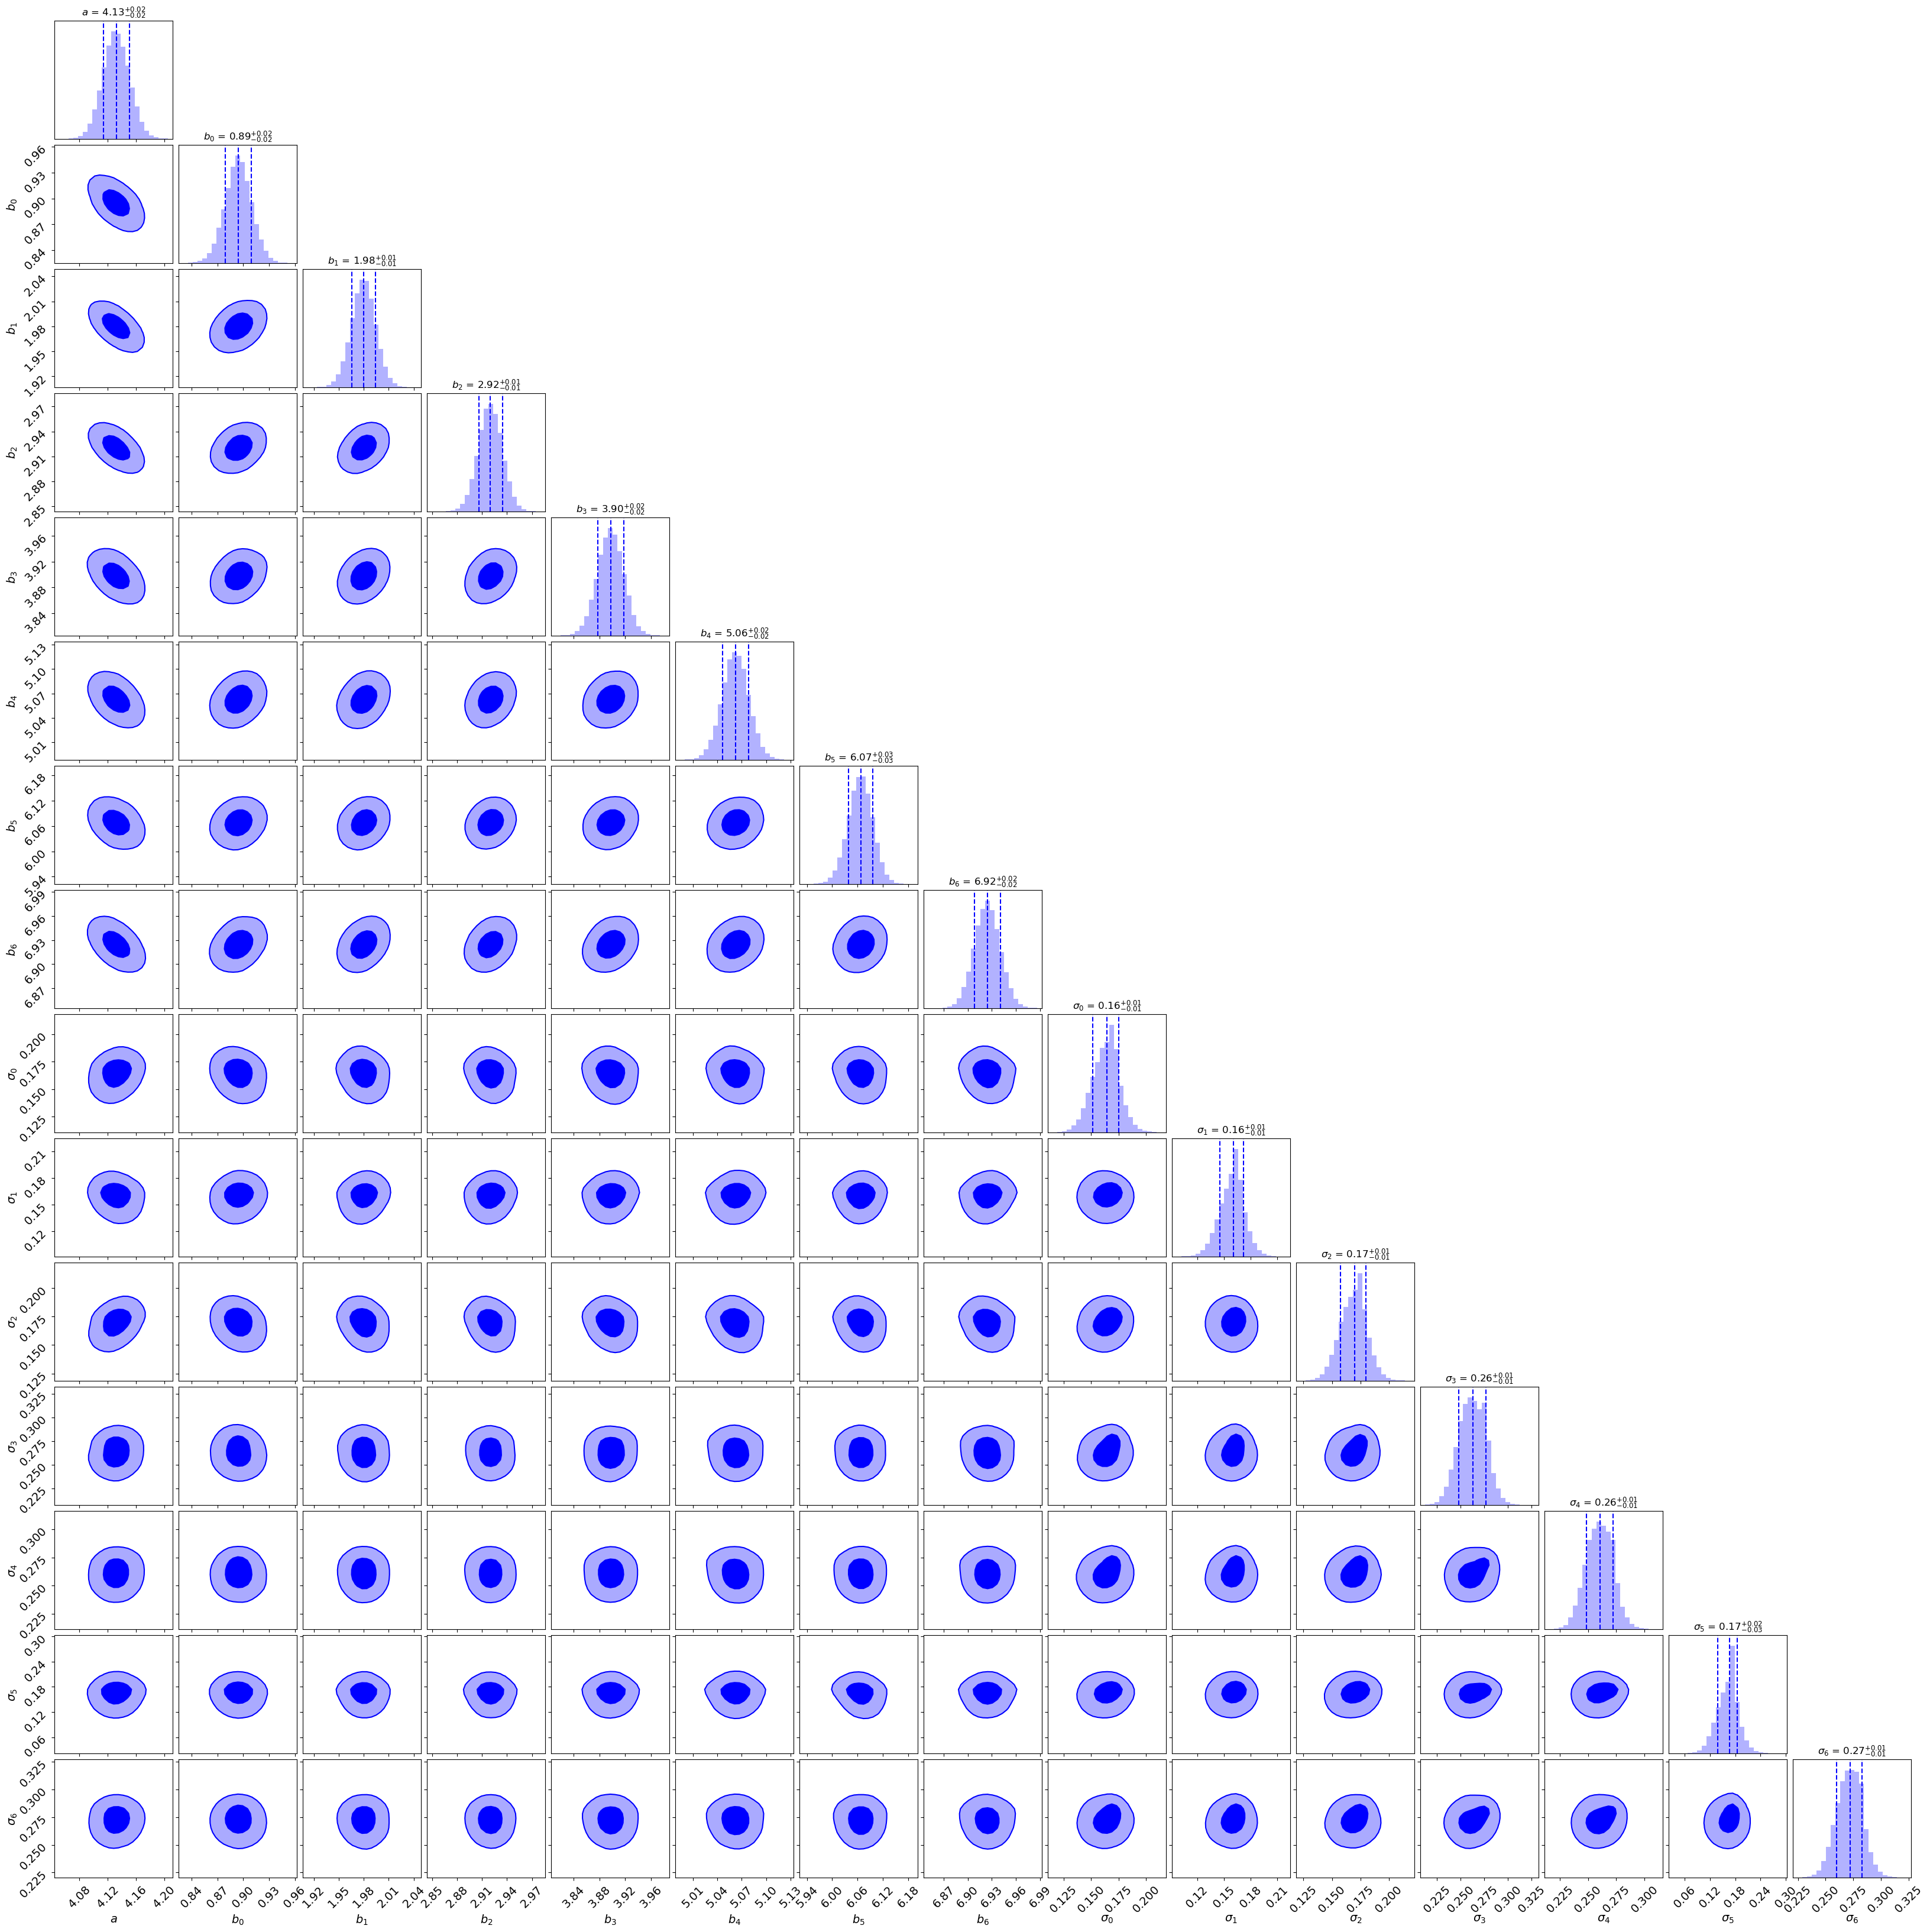

In [15]:
labels  = ['$a$']
labels += [f'$b_{k}$' for k in np.arange(m)]
labels += [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12});

# fig.savefig('multiline_fit_corner.png', dpi=100)